In [86]:
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
import torch, os, sys, torchaudio, logging, pandas as pd
from tqdm import tqdm
import pickle
import json

import sounddevice as sd
import librosa

from utils.extract_features import extract_embedding, extract_stft
from utils.split_waveform import split_waveform
from models.LSTMClassifier import LSTMClassifier

In [108]:
words = os.listdir('data/words')
word_count = len(words)

words_occurence = {}
for w in words:
    words_occurence[w] = len(os.listdir(f'data/words/{w}'))

In [ ]:
sorted_items = sorted(words_occurence.items(), key=lambda x: x[1], reverse=True)

top_100 = [item[0] for item in sorted_items[:100]] 

In [87]:
def get_max_value_from_dict(my_dict):
    if not my_dict:
        return None 
    max_key = max(my_dict, key=my_dict.get)  
    return my_dict[max_key]

def get_label(chunk_duration, idx, filename):
    interval = [chunk_duration*idx, chunk_duration*(idx+1)]
    filename = 'data/alignments/'+filename.split('.wav')[0]+'.json'
    labels = {}
    with open(filename) as jf:
        data = json.load(jf)

    for word_info in data["words"]:
        try:
            start_ms = word_info["start"] * 1000
            end_ms = word_info["end"] * 1000
            word_text = word_info["word"]
            
            if start_ms < interval[1] and end_ms > interval[0]:
                if word_text in words:
                    word_index = words.index(word_text)
                    labels[end_ms-start_ms] = word_index
        except:
            pass
            
        
    return labels

def find_words(words, label_tensor):
    indices = (label_tensor == 1).nonzero(as_tuple=False).squeeze().tolist()
    if type(indices) != list:
        indices = [indices]
    print(indices)
    return [words[i] for i in indices]

In [89]:
class AudioDataset(Dataset):
    def __init__(self, audio_dir):
        self.data = []
        self.labels = []

        for file in tqdm(os.listdir(audio_dir)[:5000]):
            logging.info(f'Loading {file} into dataset')
            if file.endswith('.wav'):
                waveform, sample_rate = torchaudio.load(f'data/wavs/{file}')
                chunk_duration = 500
                chunks = split_waveform(waveform, sample_rate,chunk_duration)

                for i in range(len(chunks) - 2):
                    # prev_embedding = extract_embedding(chunks[i], sample_rate)
                    # next_embedding = extract_embedding(chunks[i+1],sample_rate)

                    # self.data.append(prev_embedding.squeeze(0).squeeze(0))
                    # self.labels.append(next_embedding.squeeze(0).squeeze(0).squeeze(0))

                    stft = extract_stft(chunks[i].squeeze(0), sample_rate)
                    label = get_label(chunk_duration,i,file)
                    if len(label) != 0:
                        self.data.append(stft)
                        self.labels.append(get_max_value_from_dict(label))
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
audio_dir = 'data/wavs'

dataset = AudioDataset(audio_dir)

In [104]:
with open('dataset.pkl', 'wb') as file:
    pickle.dump(dataset, file)

In [ ]:
with open('dataset.pkl', 'rb') as file:
    dataset = pickle.load(file)

0 torch.Size([513, 44]) 10025


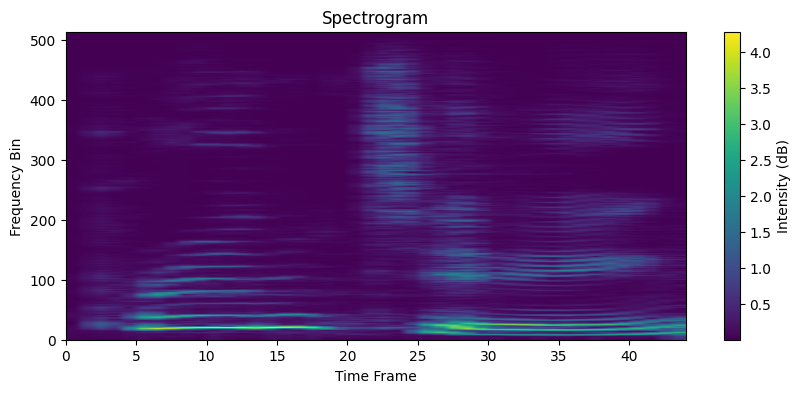

1 torch.Size([513, 44]) 10025


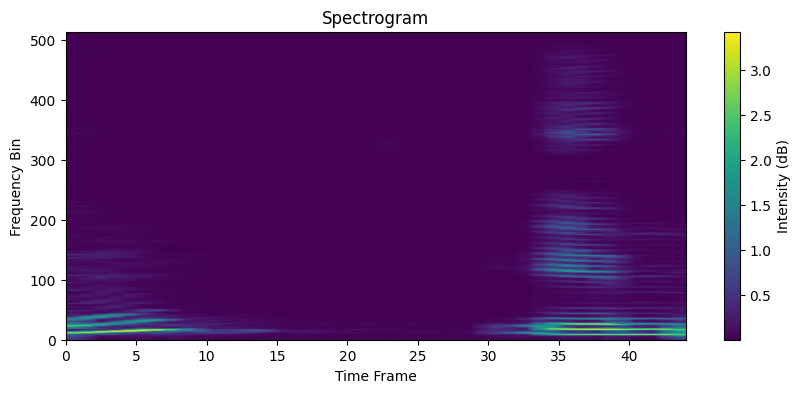

2 torch.Size([513, 44]) 12924


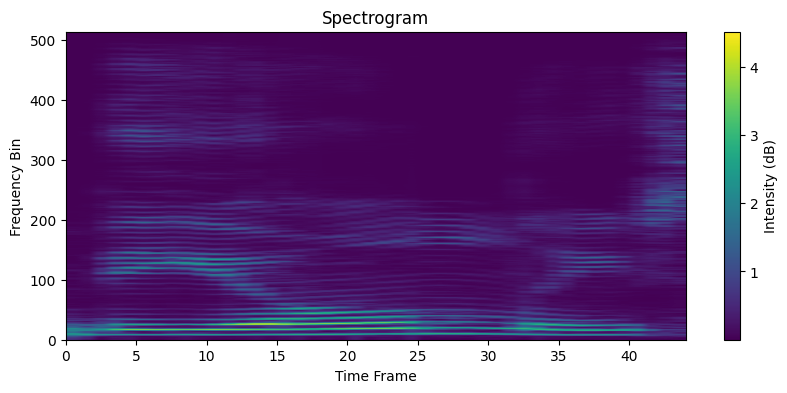

3 torch.Size([513, 44]) 14217


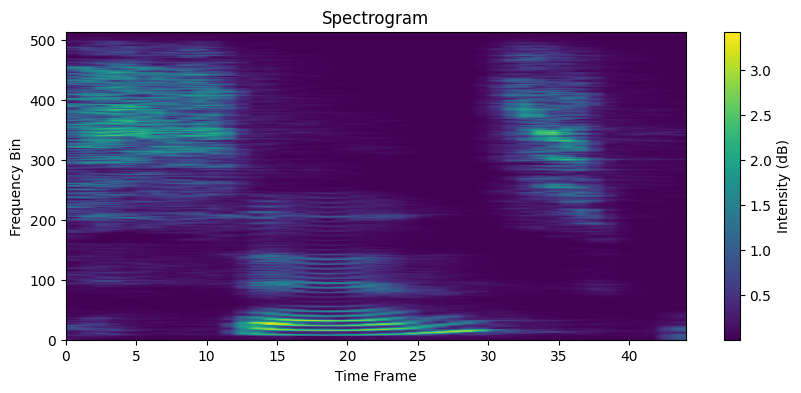

4 torch.Size([513, 44]) 14217


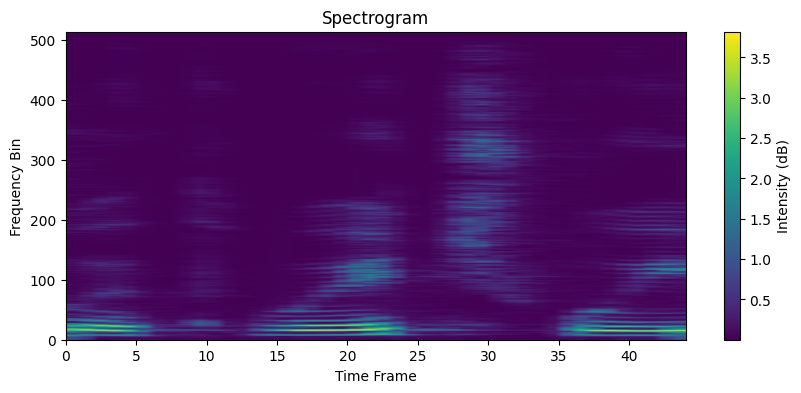

5 torch.Size([513, 44]) 14013


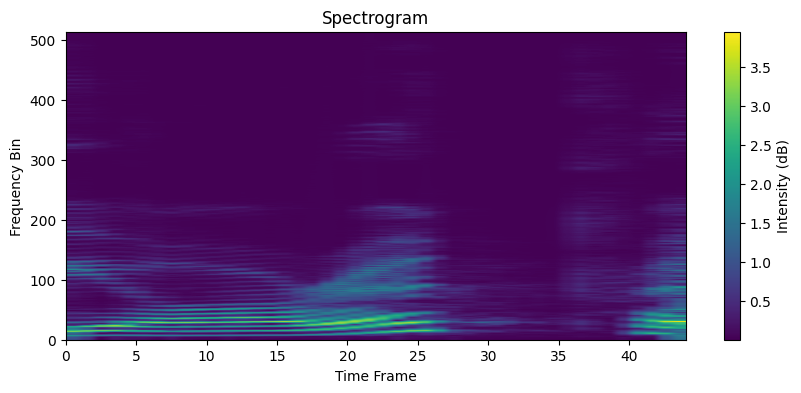

6 torch.Size([513, 44]) 9944


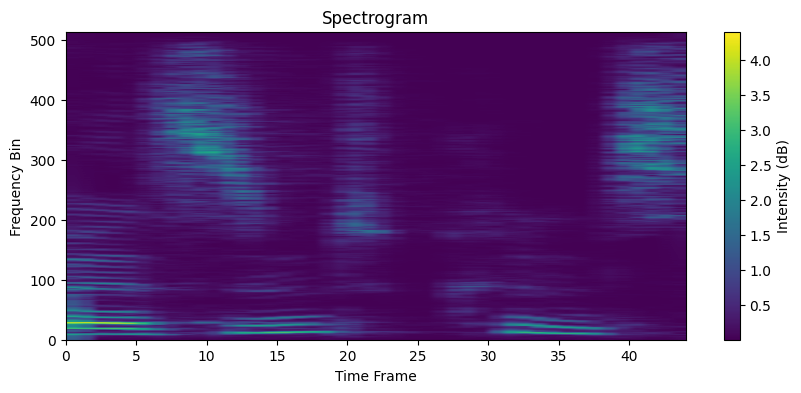

7 torch.Size([513, 44]) 2886


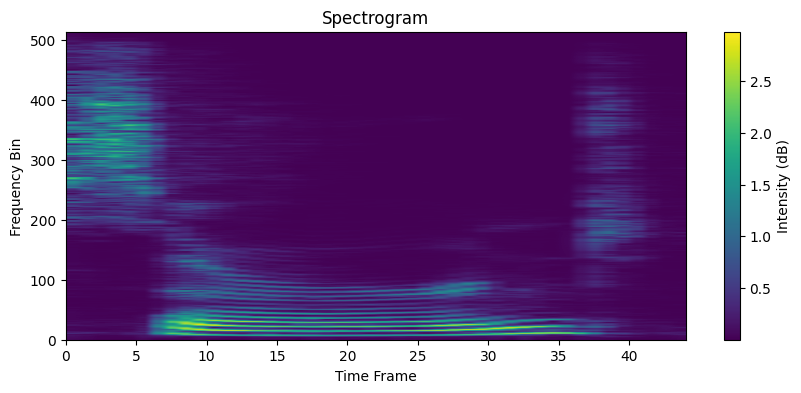

8 torch.Size([513, 44]) 3936


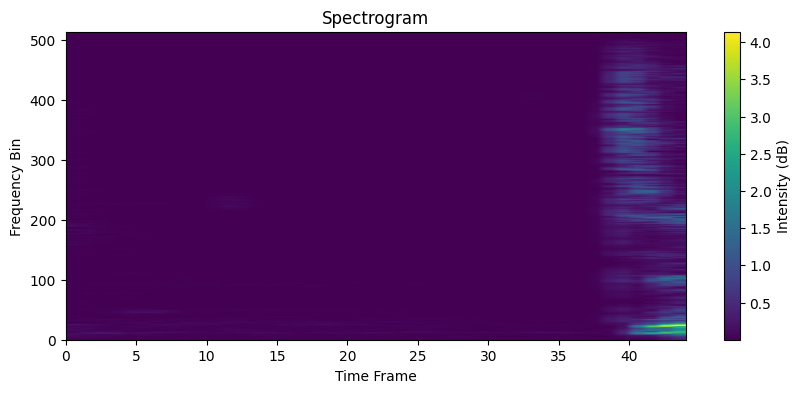

9 torch.Size([513, 44]) 3936


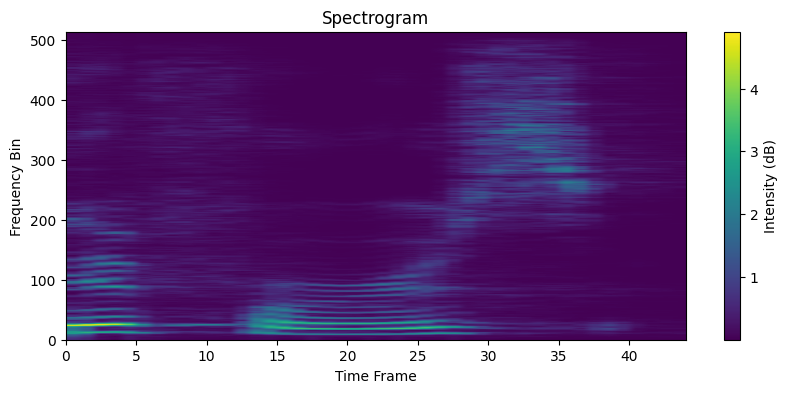

In [125]:
import matplotlib.pyplot as plt

for i in range(10):
    print(i,dataset.__getitem__(i)[0].shape,dataset.__getitem__(i)[1])

    plt.figure(figsize=(10, 4))
    plt.imshow(dataset.__getitem__(i)[0], aspect='auto', origin='lower', 
            extent=[0, dataset.__getitem__(i)[0].shape[1], 0, dataset.__getitem__(i)[0].shape[0]])

    plt.colorbar(label='Intensity (dB)')
    plt.ylabel('Frequency Bin')
    plt.xlabel('Time Frame')
    plt.title('Spectrogram')
    plt.show()

In [94]:
from torch.utils.data import random_split, DataLoader

train_ratio = 0.7
valid_ratio = 0.1
test_ratio = 0.2

total_size = len(dataset)
train_size = int(train_ratio * total_size)
valid_size = int(valid_ratio * total_size)
test_size = total_size - train_size - valid_size  # Ensures all data is used

train_dataset, remaining_dataset = random_split(dataset, [train_size, total_size - train_size])
valid_dataset, test_dataset = random_split(remaining_dataset, [valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [105]:
word_count

14386

In [103]:
from models.LSTMClassifier import LSTMClassifier

input_dim = 513
hidden_dim = 128
output_dim = word_count
num_layers = 2

model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs, labels
        optimizer.zero_grad()
        outputs = model(torch.permute(inputs, (0, 2, 1)))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss}')

    model.eval()  
    running_val_loss = 0.0
    with torch.no_grad(): 
        for inputs, labels in valid_loader:
            inputs, labels = inputs, labels
            outputs = model(torch.permute(inputs, (0, 2, 1)))
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(valid_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss}')


Epoch [1/50], Training Loss: 7.322922603289286
Epoch [1/50], Validation Loss: 7.190404070748223


KeyboardInterrupt: 

In [73]:
torch.save(model.state_dict(), 'checkpoints/multiclass_100_epochs.pt')

In [84]:
import torch

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(torch.permute(inputs, (0, 2, 1)))
        _, predicted = torch.max(outputs.data, 1)
        print(words[predicted[0]],words[labels[0]])
        total += labels.size(0)

        correct += (predicted == labels).sum()


    accuracy = 100 * correct / total

    # Print Loss
    print(f'Accuracy: {accuracy}')


to to
printer shillings
the the
there fuel
with division
propositions sessions
to the
female the
misdemeanants regained
letters inches
the the
in night
the the
the crowding
used visited
that unusually
the legislative
7 Compter
continued continued
c thirty
the the
that the
primarily man
visit design
several several
toughness went
charges they
Newgate even
their sentences
hundred imprisonment
the the
to to
fees cities
upon sympathy
should to
sometimes sometimes
who the
whole valuable
the increase
the the
prisoners prisoners
misdemeanants available
yard went
not plates
to to
thus uncertain
to two
sixteenth seventeenth
such several
of the
197 or
were portion
disorderly discharge
were wholly
side stock
picture said
saw several
judge question
only with
with the
or one
Mrs was
material of
advice fees
which which
under 275
in gallon
total chapel
Italy Bailey
6 on
should benches
1813 the
of c
Accuracy: 12.075634002685547


In [237]:
class MultiLabelLSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(MultiLabelLSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).requires_grad_()
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = self.linear(out[:, -1, :])
        return torch.sigmoid(out)  # As we are dealing with multi-label classification

input_dim = 513   # input dimension
hidden_dim = 64   # hidden layer dimension
output_dim = 14386 # output dimension
num_layers = 2    # number of LSTM layers

# Instantiate the model
model = MultiLabelLSTM(input_dim, hidden_dim, output_dim, num_layers)

# Loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Assume you have some DataLoader giving you batches of (spectrogram, labels)
# spectrogram shape: [batch_size, 513, 44]
# labels shape: [batch_size, 10]

for epoch in range(100):
    for i, (spectrograms, labels) in enumerate(train_loader):
        outputs = model(torch.permute(spectrograms, (0, 2, 1)))
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, 100, loss.item()))


Epoch [1/100], Step [100/100], Loss: 0.0184
Epoch [1/100], Step [200/100], Loss: 0.0075
Epoch [2/100], Step [100/100], Loss: 0.0033
Epoch [2/100], Step [200/100], Loss: 0.0027
Epoch [3/100], Step [100/100], Loss: 0.0019
Epoch [3/100], Step [200/100], Loss: 0.0017
Epoch [4/100], Step [100/100], Loss: 0.0015
Epoch [4/100], Step [200/100], Loss: 0.0014
Epoch [5/100], Step [100/100], Loss: 0.0013
Epoch [5/100], Step [200/100], Loss: 0.0012
Epoch [6/100], Step [100/100], Loss: 0.0012
Epoch [6/100], Step [200/100], Loss: 0.0013
Epoch [7/100], Step [100/100], Loss: 0.0012
Epoch [7/100], Step [200/100], Loss: 0.0012
Epoch [8/100], Step [100/100], Loss: 0.0011
Epoch [8/100], Step [200/100], Loss: 0.0011
Epoch [9/100], Step [100/100], Loss: 0.0010


KeyboardInterrupt: 

In [247]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []

with torch.no_grad():  # Inference without gradient calculation
    for i, (spectrograms, labels) in enumerate(test_loader):
        # Forward pass
        outputs = model(torch.permute(spectrograms, (0, 2, 1)))

        # Apply threshold to obtain binary results
        predictions = (outputs > 0.5).int()

        all_predictions.append(predictions)
        all_labels.append(labels)

# Concatenate all results
all_predictions = torch.cat(all_predictions, dim=0)
all_labels = torch.cat(all_labels, dim=0)


# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='micro')
recall = recall_score(all_labels, all_predictions, average='micro')
f1 = f1_score(all_labels, all_predictions, average='micro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


c:\Repos\mlsp-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.015611814345991562
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming your input is a spectrogram of shape [513, 44] for each instance
input_shape = (513, 44)  # as mentioned [frequency_bins, time_bins]
num_classes = 14386  # You want to classify among 10 classes

class MultiLabelCNN(nn.Module):
    def __init__(self):
        super(MultiLabelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 513, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Calculate the size of the features after the convolution and pooling layers
        # This depends on your network architecture and input size
        feature_size = self._get_conv_output(input_shape)

        # Fully connected layers
        self.fc1 = nn.Linear(feature_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    # Forward pass
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Using Sigmoid because it's a multi-label classification
        return x

    # Function for calculating the size of the features after conv and pool layers
    def _get_conv_output(self, shape):
        bs = 32  # batch size
        input = torch.autograd.Variable(torch.rand(bs, 1, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        return x

# Initialize the network
model = MultiLabelCNN()

# Define Loss and Optimizer
criterion = nn.BCELoss()  # Use Binary Cross Entropy loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Assuming you have your data loader ready with multi-label one-hot encoded targets
for inputs, targets in train_loader:
    optimizer.zero_grad()
    outputs = model(torch.permute(inputs, (0, 2, 1)))
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MultiLabelNN(nn.Module):
    def __init__(self):
        super(MultiLabelNN, self).__init__()
        self.conv1 = nn.Conv1d(44, 16, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        
        conv_out_size = self._get_conv_out(513)

        self.fc1 = nn.Linear(conv_out_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 14386) 

    def _get_conv_out(self, size):
        out = self.pool(self.conv1(torch.zeros(1, 44, size)))
        out = self.pool(self.conv2(out))
        return int(torch.numel(out)/out.shape[0])

    def forward(self, x):
        x = x.permute(0, 2, 1) 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

model = MultiLabelNN()

loss_function = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


In [35]:
total = 0
correct = 0

model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass
        try:
            outputs = model(inputs)
            predicted = outputs.data > 0.5
            total += labels.size(0)
            for i in range(len(predicted)): 
                if predicted[i] == labels[i]:
                    correct +=1
        except:
            pass
print(correct, total)
# Calculate the accuracy across all test data
accuracy = correct / total
print(f'Accuracy: {accuracy:.2f}')


0 2370
Accuracy: 0.00
